In [37]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import r2_score

In [38]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
NUM_TEST = 559
K = 24
NUM_ITERS = 10000
STATE_SPACE = range(2, 15)

In [40]:
stock = 'Google stocks.csv'

In [65]:
dataset = np.genfromtxt(stock, delimiter=',')  # Change delimiter to ','
close_prices = dataset[1:, 1]  # Extract 'Close' price from the second column
close_prices = close_prices.reshape(-1,1) 

In [66]:
close_prices.shape

(5138, 1)

In [43]:
likelihood_vect, aic_vect, bic_vect = [], [], []
for states in STATE_SPACE:
    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
    model.fit(close_prices[NUM_TEST:])
    likelihood_vect.append(model.score(close_prices))
    aic_vect.append(-2 * model.score(close_prices) + 2 * (states**2 + states))
    bic_vect.append(-2 * model.score(close_prices) + (states**2 + states) * np.log(close_prices.shape[0]))
opt_states = np.argmin(bic_vect) + 2
print(f'Optimum number of states for {stock}: {opt_states}')

Optimum number of states for Google stocks.csv: 14


In [69]:
predicted_close_prices = np.empty(NUM_TEST)
predicted_stock_data = np.empty([0,dataset.shape[1]])

In [71]:
for idx in reversed(range(NUM_TEST)):
        train_dataset = close_prices[idx + 1:,:]
        test_data = dataset[idx,:]; 
        num_examples = train_dataset.shape[0]
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # Retune the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior 
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx] - train_dataset[likelihood_diff_idx + 1]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1] + predicted_change))

In [ ]:
r2 = r2_score(predicted_stock_data, np.flipud(dataset[range(559),:]))
print('r2 for the stock {} is '.format(stock),r2)

In [33]:
for idx in reversed(range(NUM_TEST)):
        train_dataset = close_prices[idx + 1:]
        test_data = close_prices[idx]

        # Initialize HMM with optimal number of states
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))
        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        # Predict next step
        num_examples = train_dataset.shape[0]
        iters = 1
        past_likelihood = []  # Initialize as an empty list
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1]))
        while iters < num_examples / K - 1:
            past_likelihood.append(model.score(np.flipud(train_dataset[iters:iters + K - 1])))
            iters += 1

        # Calculate the absolute difference between the current likelihood and all past likelihoods
        likelihood_diff = np.abs(curr_likelihood - np.array(past_likelihood))
        likelihood_diff_idx = np.argmin(likelihood_diff)
        predicted_change = train_dataset[likelihood_diff_idx] - train_dataset[likelihood_diff_idx + 1]
        predicted_close_prices[idx] = close_prices[idx + 1] + predicted_change

In [34]:
r2 = r2_score(close_prices[:NUM_TEST], predicted_close_prices)
print(f'R2 score : {r2}')

R-squared for Google stocks.csv: 0.9927032676354112


In [35]:
mape = np.mean(np.abs((predicted_close_prices - close_prices[:NUM_TEST]) / close_prices[:NUM_TEST]))
print(f'MAPE for {stock}: {mape}')

MAPE for Google stocks.csv: 0.49283971917972075


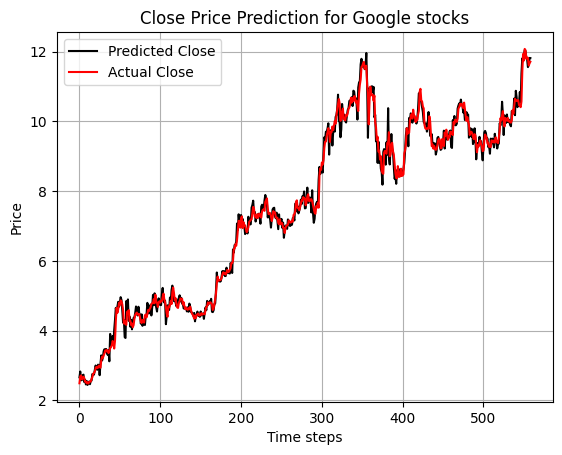

In [36]:
plt.figure()
plt.plot(range(NUM_TEST), predicted_close_prices, 'k-', label='Predicted Close')
plt.plot(range(NUM_TEST), close_prices[:NUM_TEST], 'r-', label='Actual Close')
plt.xlabel('Time steps')
plt.ylabel('Price')
plt.title('Close Price Prediction for ' + stock[:-4])
plt.grid(True)
plt.legend(loc='upper left')
plt.show()